In [1]:
import ray, logging, pickle

import pandas as pd
import numpy as np
from scipy.sparse import vstack, load_npz
import xml.etree.ElementTree as etree

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report

%matplotlib inline

In [2]:
# Start Ray. If you're connecting to an existing cluster, you would use
# ray.init(address=<cluster-address>) instead.
ray.init(logging_level=logging.ERROR)

{'node_ip_address': '172.17.0.2',
 'raylet_ip_address': '172.17.0.2',
 'redis_address': '172.17.0.2:6379',
 'object_store_address': '/tmp/ray/session_2021-06-16_18-50-41_374341_172/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-06-16_18-50-41_374341_172/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2021-06-16_18-50-41_374341_172',
 'metrics_export_port': 65324,
 'node_id': '1ade9eab55441fd1087169b80e19824e573f89ea8b13d6772f28092c'}

In [3]:
@ray.remote
def parse_post(xml):
    post = { k: v for (k, v) in etree.fromstring(xml).items() if k in ['Id', 'Title', 'Body', 'AcceptedAnswerId', 'Score'] }
    return post

In [5]:
# Posts.xml can be downloaded from 
futures = [parse_post.remote(xml) for xml in open('data/Posts.xml', 'r') ]

In [6]:
posts = ray.get(futures)

In [7]:
len(posts)

340838

In [8]:
posts[0]

{'Id': '1',
 'AcceptedAnswerId': '15',
 'Score': '48',
 'Body': '<p>How should I elicit prior distributions from experts when fitting a Bayesian model?</p>\n',
 'Title': 'Eliciting priors from experts'}

In [9]:
df = pd.DataFrame(posts)

In [10]:
df.head()

,Id,AcceptedAnswerId,Score,Body,Title
0,1,15,48,<p>How should I elicit prior distributions fro...,Eliciting priors from experts
1,2,59,34,<p>In many different statistical methods there...,What is normality?
2,3,5,71,<p>What are some valuable Statistical Analysis...,What are some valuable Statistical Analysis op...
3,4,135,23,<p>I have two groups of data. Each with a dif...,Assessing the significance of differences in d...
4,5,NaN,90,"<p>The R-project</p>\n\n<p><a href=""http://www...",NaN


In [11]:
df['Score'] = df['Score'].astype(int)

<AxesSubplot:ylabel='Density'>

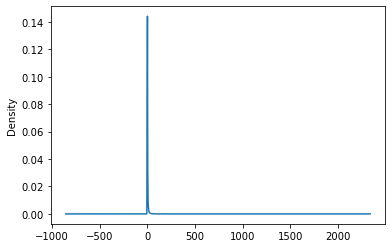

In [12]:
df.Score.plot.kde()

In [13]:
df.Score.describe()

count    340838.000000
mean          3.101990
std           9.324895
min         -56.000000
25%           1.000000
50%           1.000000
75%           3.000000
max        1541.000000
Name: Score, dtype: float64

In [14]:
df.head()

,Id,AcceptedAnswerId,Score,Body,Title
0,1,15,48,<p>How should I elicit prior distributions fro...,Eliciting priors from experts
1,2,59,34,<p>In many different statistical methods there...,What is normality?
2,3,5,71,<p>What are some valuable Statistical Analysis...,What are some valuable Statistical Analysis op...
3,4,135,23,<p>I have two groups of data. Each with a dif...,Assessing the significance of differences in d...
4,5,NaN,90,"<p>The R-project</p>\n\n<p><a href=""http://www...",NaN


In [15]:
filtered = df.dropna(subset=['Body', 'Title']).copy()

In [16]:
filtered.describe()

,Score
count,171236.00000
mean,2.73919
std,8.65931
min,-14.00000
25%,0.00000
50%,1.00000
75%,3.00000
max,1118.00000


In [17]:
(filtered.Score > 10).sum()

6899

In [18]:
filtered['label'] = filtered.Score > 10

In [19]:
filtered.head()

,Id,AcceptedAnswerId,Score,Body,Title,label
0,1,15,48,<p>How should I elicit prior distributions fro...,Eliciting priors from experts,True
1,2,59,34,<p>In many different statistical methods there...,What is normality?,True
2,3,5,71,<p>What are some valuable Statistical Analysis...,What are some valuable Statistical Analysis op...,True
3,4,135,23,<p>I have two groups of data. Each with a dif...,Assessing the significance of differences in d...,True
5,6,NaN,458,"<p>Last year, I read a blog post from <a href=...",The Two Cultures: statistics vs. machine learn...,True


In [20]:
filtered.label.value_counts()

False    164337
True       6899
Name: label, dtype: int64

In [21]:
features = filtered[(filtered.Score < 1) & (filtered.label == False)].sample(n=7500).append(filtered[filtered.label == True])

In [22]:
features.label.value_counts()

False    7500
True     6899
Name: label, dtype: int64

In [23]:
X_train, X_test, y_train, y_test = train_test_split(features.Body.values, features.label.values, test_size=0.2)

In [24]:
# with open('data/test_data.pickle', "wb") as f:
#     pickle.dump({"X": X_test, "y": y_test}, f)

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [26]:
vectorizer = TfidfVectorizer(stop_words='english')

In [27]:
X_vectors = vectorizer.fit_transform(X_train)
test_vectors = vectorizer.transform(X_test)

In [28]:
clf = LogisticRegression(solver='liblinear')

In [29]:
# fit model to training data
clf.fit(X_vectors, y_train)

LogisticRegression(solver='liblinear')

In [30]:
# make predictions
predictions = clf.predict(test_vectors)
predictions

array([False, False,  True, ...,  True, False, False])

In [31]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

       False       0.76      0.76      0.76      1520
        True       0.73      0.73      0.73      1360

    accuracy                           0.75      2880
   macro avg       0.75      0.75      0.75      2880
weighted avg       0.75      0.75      0.75      2880



In [32]:
%%time

scores = np.zeros((2, 5))
penalty = ['l2', 'l1']
alpha = [1e-3, 1e-2, 1e-1, 1, 10]

for i, p in enumerate(penalty):
    for j, a in enumerate(alpha):
        clf = LogisticRegression(C=a, penalty=p, solver='liblinear')
        scores[i, j] = cross_val_score(clf, X_vectors, y_train, cv=3).mean()

CPU times: user 4.76 s, sys: 0 ns, total: 4.76 s
Wall time: 3.85 s


<AxesSubplot:>

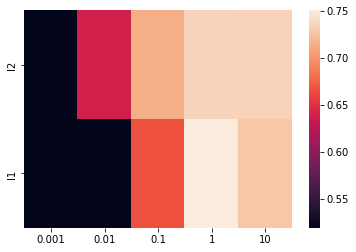

In [33]:
sns.heatmap(scores[:, :], xticklabels=alpha, yticklabels=penalty)

In [34]:
scores.argmax()

8

In [35]:
scores.max()

0.7504121398439988

In [36]:
# Create model with best performing hyperparameters
clf = LogisticRegression(C=1, penalty='l1', solver='liblinear')

# Fit on all of your (training) data
clf.fit(X_vectors, y_train)

LogisticRegression(C=1, penalty='l1', solver='liblinear')

In [37]:
# Evaluate on Holdout set
print(clf.score(test_vectors, y_test))

0.7597222222222222


In [38]:
# with open('data/model.pickle', "wb") as f:
#     pickle.dump(clf, f)

In [39]:
# with open('data/tfidf.pickle', "wb") as f:
#     pickle.dump(vectorizer, f)